In [25]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [26]:
df = pd.read_excel('沪深300.xlsx', header=3)
df = df.dropna(axis = 1, how = 'all')

bool_cols = []
for column in df.columns:
    if df[column].dtype == 'bool':
        bool_cols.append(column)

df.drop(['tech_MA5', 'tech_MA20'], axis=1, inplace=True)
df['trend'] = (df['close'] < df['close'].shift(-1))
df = df.iloc[1:,]
def fill_na(df):
    for column in df.columns:
        if df[column].isnull().any() and column not in bool_cols:
            df[column].fillna(df[column].mean(), inplace=True)
    return df
df

,Date,open,high,low,close,volume,amt,dealnum,adjfactor,turn,...,stage_high,stage_low,up_days,down_days,breakout_ma,breakdown_ma,history_high_days,history_low_days,bull_bear_ma,trend
1,2012-05-29,2.602,2.661,2.602,2.644,714949008.0,1.875593e+09,11432,1.000000,6.936538,...,True,True,1.0,0.0,False,False,2,1,False,False
2,2012-05-30,2.642,2.647,2.633,2.636,265887198.0,7.017258e+08,5532,1.000000,2.595794,...,True,True,0.0,1.0,False,False,2,1,False,False
3,2012-05-31,2.621,2.645,2.613,2.630,178155984.0,4.681931e+08,4662,1.000000,1.747313,...,True,False,0.0,2.0,False,False,1,0,False,False
4,2012-06-01,2.629,2.660,2.620,2.630,179350035.0,4.734772e+08,5189,1.000000,1.766249,...,False,False,0.0,0.0,False,False,0,0,False,False
5,2012-06-04,2.601,2.604,2.555,2.558,546074272.0,1.413414e+09,7566,1.000000,5.559705,...,False,False,0.0,1.0,False,False,0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,2025-03-27,4.011,4.050,3.995,4.027,801525164.0,3.224973e+09,70576,1.207793,0.941116,...,False,False,1.0,0.0,False,False,0,0,False,False
3119,2025-03-28,4.027,4.029,4.000,4.008,704304791.0,2.826193e+09,59846,1.207793,0.828821,...,False,False,0.0,1.0,False,False,0,0,False,False
3120,2025-03-31,4.004,4.024,3.969,3.984,902172863.0,3.600807e+09,110122,1.207793,1.060626,...,False,False,0.0,2.0,False,False,0,0,False,False
3121,2025-04-01,3.988,4.003,3.979,3.982,615015541.0,2.452333e+09,58348,1.207793,0.721766,...,False,False,0.0,3.0,False,False,0,0,False,False


In [27]:
torch.manual_seed(42)
np.random.seed(42)

# Parameters
WINDOW_SIZE = 20
BATCH_SIZE = 64
TARGET_COLUMN = 'trend'
FEATURES = [col for col in df.columns if col not in ['trend', 'Date']]
#FEATURES = ['close']
#FEATURES = ['open', 'high', 'low', 'close', 'volume', 'MACD', 'RSI', 'up_days', 'down_days', 'history_high_days', 'history_low_days']
BOOL_FEATURES = [col for col in FEATURES if df[col].dtype == 'bool']
NUM_FEATURES = [col for col in FEATURES if col not in BOOL_FEATURES]
TEST_SIZE = 0.2
EPOCHS = 100
PATIENCE = 5
DEVICE = "cuda"

Dealing with time series dataset

In [28]:
class VAEDataset(Dataset):
    def __init__(self, dataframe, window_size, target_col, features):
        self.df = dataframe.copy()
        self.window_size = window_size
        self.target_col = target_col
        self.features = features

        # Convert boolean features to int
        self.df[BOOL_FEATURES] = self.df[BOOL_FEATURES].astype(int)

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        X = self.df.iloc[idx:idx + self.window_size][self.features].values
        y = self.df.iloc[idx + self.window_size][self.target_col]
        return torch.FloatTensor(X), torch.FloatTensor([y])

Model

In [29]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # latent_dim for mean and logvar
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        batch_size = x.size(0)
        x_flattened = x.view(batch_size, -1)  # Flatten input
        latent_params = self.encoder(x_flattened)
        mu, logvar = latent_params[:, :latent_params.size(1) // 2], latent_params[:, latent_params.size(1) // 2:]
        z = self.reparameterize(mu, logvar)
        reconstructed_x_flattened = self.decoder(z)
        reconstructed_x = reconstructed_x_flattened.view(batch_size, x.size(1), x.size(2))  # Reshape to original shape
        return reconstructed_x, mu, logvar

In [30]:
# Loss function
def vae_loss(reconstructed_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(reconstructed_x, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl_div


Model training

In [31]:
# Training function
def train_vae(model, train_loader, val_loader, optimizer, n_epochs, patience):
    best_model = None
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(DEVICE)
            optimizer.zero_grad()
            reconstructed_x, mu, logvar = model(X_batch)
            loss = vae_loss(reconstructed_x, X_batch, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, _ in val_loader:
                X_batch = X_batch.to(DEVICE)
                reconstructed_x, mu, logvar = model(X_batch)
                loss = vae_loss(reconstructed_x, X_batch, mu, logvar)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model, train_losses, val_losses, best_val_loss

In [32]:
# Visualization
def plot_loss(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"{model_name} Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

Model evaluation

In [33]:
# Evaluation function for VAE
def evaluate_vae_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    y_true, y_pred, y_prob_pred = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            # Forward pass through the VAE
            reconstructed_x, mu, logvar = model(X_batch)

            # Use the reconstructed representation to predict the target
            # Example: Use the mean of the last time step's reconstruction as the prediction
            preds = torch.sigmoid(reconstructed_x[:, -1, :].mean(dim=1)).cpu().numpy()
            y_prob_pred.extend(preds)
            # Convert predictions to binary labels
            y_pred.extend((preds >= 0.5).astype(int))
            y_true.extend(y_batch.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_prob_pred)

# Metrics calculation
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
    }

Backtest

In [34]:
def backtest_strategy(df):
    # Calculate daily returns based on 'close' prices
    df['daily_return'] = df['close'].pct_change()  # Percentage change in close prices
    
    # Initialize strategy returns array
    strategy_returns = []
    for i in range(len(df) - 1):  # Exclude the last row since no next-day action
        if df.loc[i, 'preds'] == 1:
            # If prediction is 1, assume we buy at today's close and sell at tomorrow's close
            strategy_return = (df.loc[i + 1, 'close'] - df.loc[i, 'close']) / df.loc[i, 'close']
        else:
            # If prediction is 0, assume we sell at today's close and buy at tomorrow's close
            strategy_return = (df.loc[i, 'close'] - df.loc[i + 1, 'close']) / df.loc[i, 'close']
        strategy_returns.append(strategy_return)
    
    # Add strategy returns to the DataFrame
    df = df.iloc[:-1]  # Exclude the last row since we can't calculate returns for it
    df['strategy_return'] = strategy_returns
    
    # Calculate cumulative returns for the strategy and index
    df['strategy_net_value'] = (1 + df['strategy_return']).cumprod()
    df['index_net_value'] = (1 + df['daily_return']).cumprod()
    
    # Calculate metrics
    total_days = len(df)
    annualized_return = (df['strategy_net_value'].iloc[-1]) ** (252 / total_days) - 1  # 252 trading days in a year
    daily_win_rate = (df['strategy_return'] > 0).mean()  # Proportion of positive daily returns
    
    df.to_excel('output2.xlsx', index=False)
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['strategy_net_value'], label='Strategy Net Value', color='blue')
    plt.plot(df['date'], df['index_net_value'], label='Index Net Value (510300.SH)', color='orange')
    plt.title('Strategy vs Index Net Value')
    plt.xlabel('Date')
    plt.ylabel('Net Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # print results
    print('Annualized Return:', annualized_return)
    print('Daily Win Rate:', daily_win_rate)
    # Return results
    results = {
        'annualized_return': annualized_return,
        'daily_win_rate': daily_win_rate,
        'strategy_net_value': df['strategy_net_value'],
        'index_net_value': df['index_net_value']
    }
    return results

Main

In [35]:
# Main function
def main_vae():
    # Split data into train and test sets
    train_size = int(len(df) * (1 - TEST_SIZE))
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    # fill the missing values
    test_data = fill_na(test_data)

    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=4)

    best_model_state = None
    best_val_loss = float('inf')
    final_train_losses = None
    final_val_losses = None
    best_fold_scaler = None

    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_data)):
        print(f"Fold {fold + 1}")
        fold_train_data = train_data.iloc[train_idx]
        fold_val_data = train_data.iloc[val_idx]

        # fill the missing values
        fold_train_data = fill_na(fold_train_data)
        fold_val_data = fill_na(fold_val_data)

        # Scale data
        scaler = StandardScaler()
        scaler.fit(fold_train_data[NUM_FEATURES])
        fold_train_data[NUM_FEATURES] = scaler.transform(fold_train_data[NUM_FEATURES])
        fold_val_data[NUM_FEATURES] = scaler.transform(fold_val_data[NUM_FEATURES])

        # Create datasets and loaders
        train_dataset = VAEDataset(fold_train_data, WINDOW_SIZE, TARGET_COLUMN, FEATURES)
        val_dataset = VAEDataset(fold_val_data, WINDOW_SIZE, TARGET_COLUMN, FEATURES)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # Model
        input_dim = WINDOW_SIZE * len(FEATURES)
        latent_dim = 64 
        hidden_dim = 512
        lr = 0.005
        weight_decay = 1e-5
        vae_model = VAE(input_dim, latent_dim, hidden_dim).to(DEVICE)
        optimizer = torch.optim.Adam(vae_model.parameters(), lr=lr, weight_decay=weight_decay)

        vae_model, train_losses, val_losses, fold_best_val_loss = train_vae(vae_model, train_loader, val_loader, optimizer, EPOCHS, PATIENCE)
        print(f"Fold {fold+1} Best Validation Loss: {fold_best_val_loss:.4f}")

        if fold_best_val_loss < best_val_loss:
            best_val_loss = fold_best_val_loss
            best_model_state = vae_model.state_dict().copy()
            final_train_losses = train_losses
            final_val_losses = val_losses
            best_fold_scaler = scaler
            print(f"Best model saved for Fold {fold+1}")

    final_model = VAE(input_dim, latent_dim, hidden_dim).to(DEVICE)
    final_model.load_state_dict(best_model_state)

    # plot losses
    plot_loss(final_train_losses, final_val_losses, 'VAE')

    # evaluation in the test set
    print("\nevaluating the model on the test set...")
    test_data[NUM_FEATURES] = best_fold_scaler.transform(test_data[NUM_FEATURES])
    test_dataset = VAEDataset(test_data, WINDOW_SIZE, TARGET_COLUMN, FEATURES)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    vae_actuals, vae_preds, vae_prob_preds = evaluate_vae_model(final_model, test_loader)
    np.save('vae_prob_preds.npy', vae_prob_preds)

    # calculate the metrics for the transformer
    vae_metrics = calculate_metrics(vae_actuals, vae_preds)

    print("\nVAE's performance:")
    for metric, value in vae_metrics.items():
        print(f"{metric}: {value:.6f}")

    return {
        'model': final_model,
        'vae_metrics': vae_metrics,
        'vae_preds': vae_preds,
        'vae_actuals': vae_actuals,
        'scaler': best_fold_scaler,
        'vae_prob_preds': vae_prob_preds
    }

Fold 1
Epoch 1, Train Loss: 127.4710, Val Loss: 69848449238.0921
Epoch 2, Train Loss: 135.9467, Val Loss: 148454983.3402
Epoch 3, Train Loss: 144.2787, Val Loss: 43753464507456.1641
Epoch 4, Train Loss: 145.0404, Val Loss: 3126605605.5838
Epoch 5, Train Loss: 135.1813, Val Loss: 10777964651.6991
Epoch 6, Train Loss: 98.3422, Val Loss: 646022106774943.8750
Epoch 7, Train Loss: 49.0486, Val Loss: 731403.3716
Epoch 8, Train Loss: 47.5663, Val Loss: 1001683.1186
Epoch 9, Train Loss: 61.9144, Val Loss: 33319895.5014
Epoch 10, Train Loss: 57.5924, Val Loss: 18444.5590
Epoch 11, Train Loss: 76.0705, Val Loss: 7055.4376
Epoch 12, Train Loss: 101.8259, Val Loss: 217843.6449
Epoch 13, Train Loss: 124.7870, Val Loss: 13574353.5698
Epoch 14, Train Loss: 153.2749, Val Loss: 716043021.7104
Epoch 15, Train Loss: 145.4601, Val Loss: 109871223816.6036
Epoch 16, Train Loss: 137.6108, Val Loss: 9255096.7994
Early stopping triggered.
Fold 1 Best Validation Loss: 7055.4376
Best model saved for Fold 1
Fold 

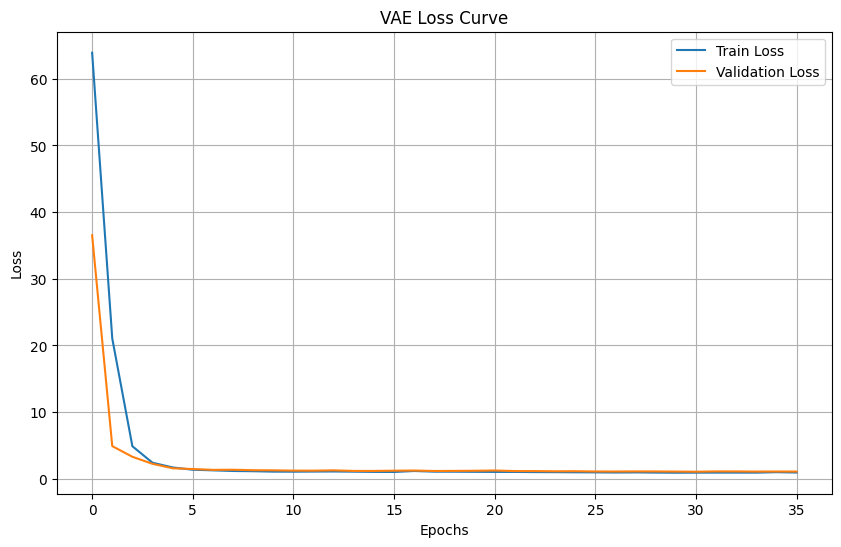


evaluating the model on the test set...

VAE's performance:
Accuracy: 0.525620
Precision: 0.477833
Recall: 0.721190
F1 Score: 0.574815


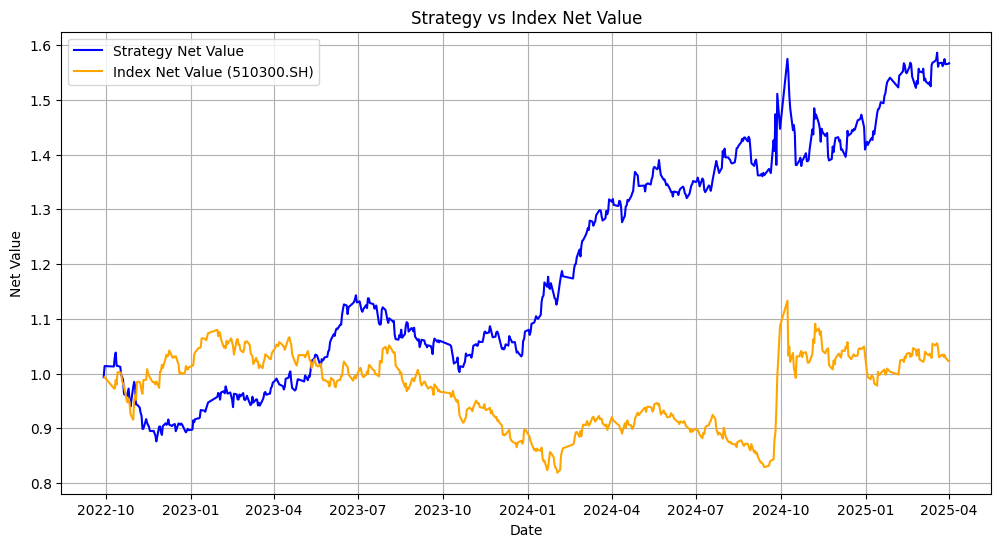

Annualized Return: 0.20614998998176515
Daily Win Rate: 0.5215231788079471



In [36]:
vae_results = main_vae()
vae_preds = vae_results['vae_preds']
vae_preds = vae_results['vae_preds'].flatten()
train_size = int(len(df) * (1 - TEST_SIZE))
vae_pred_series = pd.Series(vae_preds, index=range(train_size+WINDOW_SIZE+1, train_size+WINDOW_SIZE+1 + len(vae_preds)))
df['vae_preds'] = vae_pred_series
vae_backtest = df.loc[train_size+WINDOW_SIZE+1:, ['Date', 'close', 'vae_preds']]
vae_backtest.rename(columns={'vae_preds': 'preds', 'Date':'date'}, inplace=True)
vae_backtest.reset_index(drop=True, inplace=True)
vae_backtest.to_excel('vae_output.xlsx', index=False)
backtest_strategy(vae_backtest)
print()